# Figure 2

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
import scvelo as scv

import milopy.core as milo
import milopy.plot as milopl

In [221]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/writing/ms_figures/draft_panels/assemble_fig2/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir

In [6]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [7]:
%load_ext rpy2.ipython


In [8]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [43]:
## Load organ color palette
org_colors = pd.read_csv("../metadata/organ_colors.csv", index_col=0)

### Load dataframes for plotting

In [628]:
mye_milo_time = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/milo_outs/MYELOID_V2/milo_beeswarm_plot_data.MYELOID_V2.csv', index_col=0)
mye_milo_organ = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/milo_organ_outs/MYELOID_V2/milo_heatmap_plot_data.MYELOID_V2.csv', index_col=0)
mye_adult_heatmap = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/panimmune_MYELOID_query.mapped2MYELOID_V2.confusion_table.csv', index_col=0)

lym_milo_time = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/milo_outs/LYMPHOID/milo_beeswarm_plot_data.LYMPHOID.csv', index_col=0)
lym_milo_organ = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/milo_organ_outs/LYMPHOID/milo_heatmap_plot_data.LYMPHOID.csv', index_col=0)
lym_adult_heatmap = pd.read_csv('/nfs/team205/ed6/data/Fetal_immune/panimmune_LYMPHOID_query.mapped2LYMPHOID.confusion_table.csv', index_col=0)


In [447]:
## Read full annotation
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

In [13]:
## Read annotation groupings
import json
with open('../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)

## Define annotation groupings / ordering

In [30]:
# anno_obs_mye = anno_obs[anno_obs.anno_lvl_2_final_clean.isin(anno_groups_dict["MYELOID"])].copy()
# anno_obs_lym = anno_obs[anno_obs.anno_lvl_2_final_clean.isin(anno_groups_dict['ILC'] + anno_groups_dict['B CELLS'] + anno_groups_dict['NK/T CELLS'])].copy()

In [465]:
anno_group_myeloid = {
    "Progenitors":['CMP','DC_PROGENITOR','GMP','MOP','MYELOCYTE','PROMONOCYTE','PROMYELOCYTE'],
    "Granulocytes":['NEUTROPHIL', 'MAST_CELL', 'EOSINOPHIL_BASOPHIL'],
    'DCs':[x for x in anno_obs_mye.anno_lvl_2_final_clean.unique() if "DC" in x],
    "Mono":[x for x in anno_obs_mye.anno_lvl_2_final_clean.unique() if x.startswith("MONO")],
    "MACs":[x for x in anno_obs_mye.anno_lvl_2_final_clean.unique() if "ACROPHAGE" in x or "MICROGLIA" in x]
    }

anno_group_myeloid['other'] = [x for x in anno_obs_mye.anno_lvl_2_final_clean.unique() if x not in sum(anno_group_myeloid.values(),[])]
anno_group_myeloid_rev = {x:g for g,a in anno_group_myeloid.items() for x in a}

# ## Exclude low quality
# anno_group_myeloid_rev = {k:("other" if k in anno_groups_dict['OTHER'] else v) for k,v in anno_group_myeloid_rev.items()}
# anno_group_myeloid = dict()
# for k,v in anno_group_myeloid_rev.items():
#     if v not in anno_group_myeloid.keys(): 
#         anno_group_myeloid[v] = []
#     anno_group_myeloid[v].append(k)

In [542]:
## Add annotation grouping
anno_group_lymphoid = {
    "NK cells":[x for x in anno_obs_lym.anno_lvl_2_final_clean.unique() if x.endswith("NK")],
    "ILCs":[x for x in anno_obs_lym.anno_lvl_2_final_clean.unique() if x.startswith("ILC")],
    "B cells":[x for x in anno_obs_lym.anno_lvl_2_final_clean.unique() if x.endswith("B") or x=="B1"],
    "T cells":[x for x in anno_obs_lym.anno_lvl_2_final_clean.unique() if x.endswith("T") or x=="ABT(ENTRY)" or x=="CD8AA"],
   "Progenitors":anno_groups_dict["PROGENITORS"]
    }

anno_group_lymphoid['other'] = [x for x in anno_obs_lym.anno_lvl_2_final_clean.unique() if x not in sum(anno_group_lymphoid.values(),[])]
anno_group_lymphoid_rev = {x:g for g,a in anno_group_lymphoid.items() for x in a}

anno_group_lymphoid
# ## Exclude low quality
# anno_group_lymphoid_rev = {k:("other" if k in anno_groups_dict['OTHER'] else v) for k,v in anno_group_myeloid_rev.items()}
# anno_group_myeloid = dict()
# for k,v in anno_group_myeloid_rev.items():
#     if v not in anno_group_myeloid.keys(): 
#         anno_group_myeloid[v] = []
#     anno_group_myeloid[v].append(k)

{'NK cells': ['NK', 'CYCLING_NK'],
 'ILCs': ['ILC3', 'ILC2'],
 'B cells': ['LARGE_PRE_B',
  'PRE_PRO_B',
  'PRO_B',
  'CYCLING_B',
  'SMALL_PRE_B',
  'MATURE_B',
  'B1',
  'IMMATURE_B',
  'LATE_PRO_B',
  'PLASMA_B',
  'DOUBLET_ERY_B',
  'MONOCYTE_II_IL1B'],
 'T cells': ['LOW_Q_INCONSISTENT',
  'CYCLING_T',
  'CD4+T',
  'CD8+T',
  'NK_T',
  'DOUBLET',
  'DP(P)_T',
  'CD8AA',
  'ABT(ENTRY)',
  'DP(Q)_T',
  'DN(P)_T',
  'DN(early)_T',
  'DN(Q)_T'],
 'Progenitors': ['MEMP',
  'GMP',
  'LMPP_ELP',
  'HSC_MPP',
  'MEP',
  'CMP',
  'CYCLING_MEMP',
  'CYCLING_MPP'],
 'other': ['TREG',
  'DC_PROGENITOR',
  'CYCLING_ILC',
  'HIGH_MITO',
  'PRE_DC2',
  'CYCLING_PDC',
  'MAST_CELL',
  'CYCLING_DC2',
  'MACROPHAGE_I',
  'EARLY_MK',
  'PDC',
  'DC3',
  'DC2',
  'TH17',
  'FIBROBLAST_IV',
  'PROMYELOCYTE',
  'DC1',
  'MOP',
  'PROMONOCYTE',
  'MACROPHAGE_V',
  'EOSINOPHIL_BASOPHIL',
  'CYCLING_DC3',
  'MACROPHAGE_II',
  'AS_DC',
  'MACROPHAGE_III',
  'MIGRATORY_DC',
  'MONOCYTE_III_CCR2']}

In [543]:
anno_group_lymphoid = {
    'NK cells': ['NK', 'CYCLING_NK'],
    'ILCs': ['ILC2','ILC3','CYCLING_ILC'],
    'B cells': [
      'PRE_PRO_B',
          'PRO_B',
        'LATE_PRO_B',
        'LARGE_PRE_B',
        'SMALL_PRE_B',
    'IMMATURE_B',
      'MATURE_B',
      'B1',
  'CYCLING_B',
      'PLASMA_B'],
    'Developing T cells': [              
                'DN(early)_T',
                'DN(Q)_T',
                'DN(P)_T',
                'DP(P)_T',
                'DP(Q)_T',
                'ABT(ENTRY)'
               ],
    'Conventional SP T cells':['CYCLING_T',
                'CD4+T',
                'CD8+T'
    ],
 'Unconventional T cells': ['TREG', 'NK_T', 'TH17','CD8AA'],
    "other":['HIGH_MITO','DOUBLET_ERY_B']}

anno_group_lymphoid_rev = {x:g for g,a in anno_group_lymphoid.items() for x in a}

In [623]:
anno_group_myeloid = {
    'Progenitors': ['CMP',
  'GMP',
  'MOP',
  'MYELOCYTE',
  'PROMONOCYTE',
  'PROMYELOCYTE'],
 'DCs': ['DC_PROGENITOR',
         'PRE_DC1',
         'PRE_DC2',
         'DC3',
         'DC1',
         'CYCLING_DC2',
         'CYCLING_DC3',
         'DC2',
         'PDC',
         'CYCLING_PDC',
         'MIGRATORY_DC',
         'AS_DC'],
 'Granulocytes': ['NEUTROPHIL', 'MAST_CELL', 'EOSINOPHIL_BASOPHIL'],
 'Mono': ['MONOCYTE_I_CXCR4', 'MONOCYTE_III_CCR2', 'MONOCYTE_II_IL1B'],
 'MACs': ['MACROPHAGE_III',
          'MACROPHAGE_IV',
          'MACROPHAGE_I',
#           'MACROPHAGE_VI_PERI',
#           'MACROPHAGE_VII_ERY',
          'MACROPHAGE_II',
          'MACROPHAGE_V',
          'MICROGLIA_P2RY12'],
 'other': ['FIBROBLAST_IV',
  'HSC_MPP',
  'LC',
  'MEMP',
  'EARLY_MK',
  'OSTEOCLAST',
  'LMPP_ELP',
           'LOW_QUALITY_MACROPHAGE'
          ]
}

anno_group_myeloid_rev = {x:g for g,a in anno_group_myeloid.items() for x in a}

In [480]:
organ_order = ['YS', "LI", "BM", "TH","SP", "MLN", 'SK', "KI", "GU"]

## Myeloid

### Embedding

In [602]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"
split="MYELOID_V2"

In [603]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"

In [604]:
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split), backed="r")
adata.var_names_make_unique()

In [605]:
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
anno_obs_mye = anno_obs.loc[adata.obs_names[adata.obs_names.isin(anno_obs.index)]].copy()

In [606]:
anno_obs = anno_obs_mye.copy()
anno_group = anno_group_myeloid.copy()
anno_group_rev = anno_group_myeloid_rev.copy()

org_count_df = anno_obs_mye.groupby(["organ", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
org_count_df["anno_group"] = [anno_group_rev[x] if x in anno_group_rev.keys() else np.nan for x in org_count_df.anno_lvl_2_final_clean]
org_count_df["anno"] = org_count_df["anno_lvl_2_final_clean"]

age_count_df = anno_obs_mye.groupby(["age", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
age_count_df["anno_group"] = [anno_group_rev[x] if x in anno_group_rev.keys() else np.nan for x in age_count_df.anno_lvl_2_final_clean]
age_count_df["anno"] = age_count_df["anno_lvl_2_final_clean"]

anno_group_order = list(anno_group.keys())
anno_order = sum([v for v in anno_group.values()],[])

In [607]:
adata.obs['anno_lvl_2_final_clean'] = np.nan
adata.obs.loc[adata.obs_names.isin(anno_obs_mye.index), 'anno_lvl_2_final_clean'] = anno_obs_mye.loc[adata.obs_names[adata.obs_names.isin(anno_obs_mye.index)]]['anno_lvl_2_final_clean']

In [608]:
anno_numbering = {anno_order[i]:str(i+1) for i in range(len(anno_order))}
adata.obs['anno_number'] = [anno_numbering[x] if x in anno_order else np.nan for x in adata.obs['anno_lvl_2_final_clean']]

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/writing/ms_figures/draft_panels/assemble_fig2/scvelo_MYELOID_V2_annotation_embedding.png


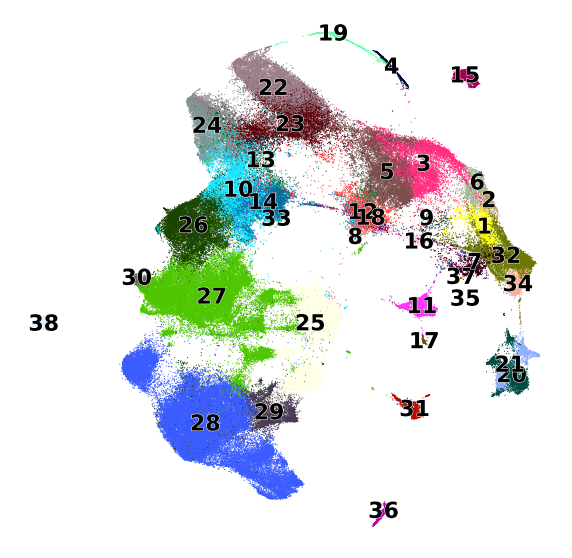

In [609]:
plt.rcParams['figure.figsize'] = [10,10]
scv.pl.umap(adata, color=['anno_number'], 
            title="", legend_fontsize=22, size=5,
#             groups=,
            save='MYELOID_V2_annotation_embedding.png'
           )

Make legend

In [610]:
color_dict = dict(zip(adata.obs['anno_number'].cat.categories, adata.uns['anno_number_colors']))
anno_order_labels = ["({n}) {a}".format(n=str(i+1),a=anno_order[i]) for i in range(len(anno_order))]
anno_number = ["{n}".format(n=str(i+1)) for i in range(len(anno_order))]

anno_order_df = pd.DataFrame([anno_order_labels, anno_order]).T
anno_order_df.columns = ['anno_order_labels', 'anno_lvl_2_final_clean']
anno_order_df['anno_number'] = [anno_numbering[x] for x in anno_order_df['anno_lvl_2_final_clean']]
anno_order_df['anno_color'] = [color_dict[x] for x in anno_order_df['anno_number']]
anno_order_df['anno_group'] = [anno_group_myeloid_rev[x] for x in anno_order_df['anno_lvl_2_final_clean']]

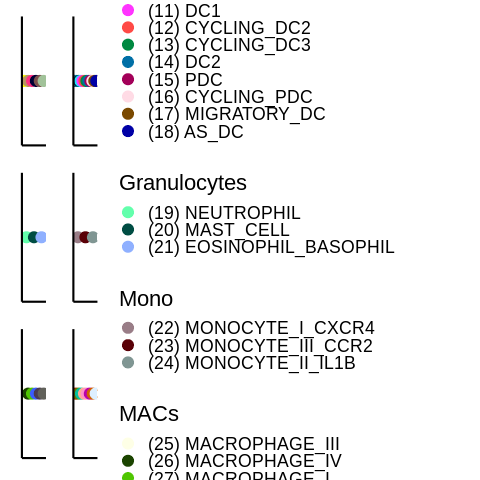

In [611]:
%%R -i anno_order_df 
library(ggpubr)
anno_order_df$anno_order_labels <- factor(anno_order_df$anno_order_labels, levels=anno_order_df$anno_order_labels)
leg_ls <- lapply(unique(anno_order_df$anno_group), function(g) {
    pl <- anno_order_df %>%
    filter(anno_group==g) %>%
    ggplot(aes(anno_order_labels, 1, color=anno_order_labels)) +
    geom_point(size=5) +
    theme_classic(base_size=22) +
    remove_x_axis() +
    remove_y_axis() +
    scale_color_manual(values=setNames(anno_order_df$anno_color, anno_order_df$anno_order_labels),
                      name=g)
#     leg <- get_legend(pl)
#     leg
    pl
    }
)

(wrap_plots(leg_ls, ncol=2) +
plot_layout(guides='collect') & 
theme(legend.justification = "left") &
guides(color=guide_legend(ncol = 1))) +
ggsave(paste0(figdir, "mye_embedding_legend.pdf"), height=15, width=12)

### Organ / age distribution

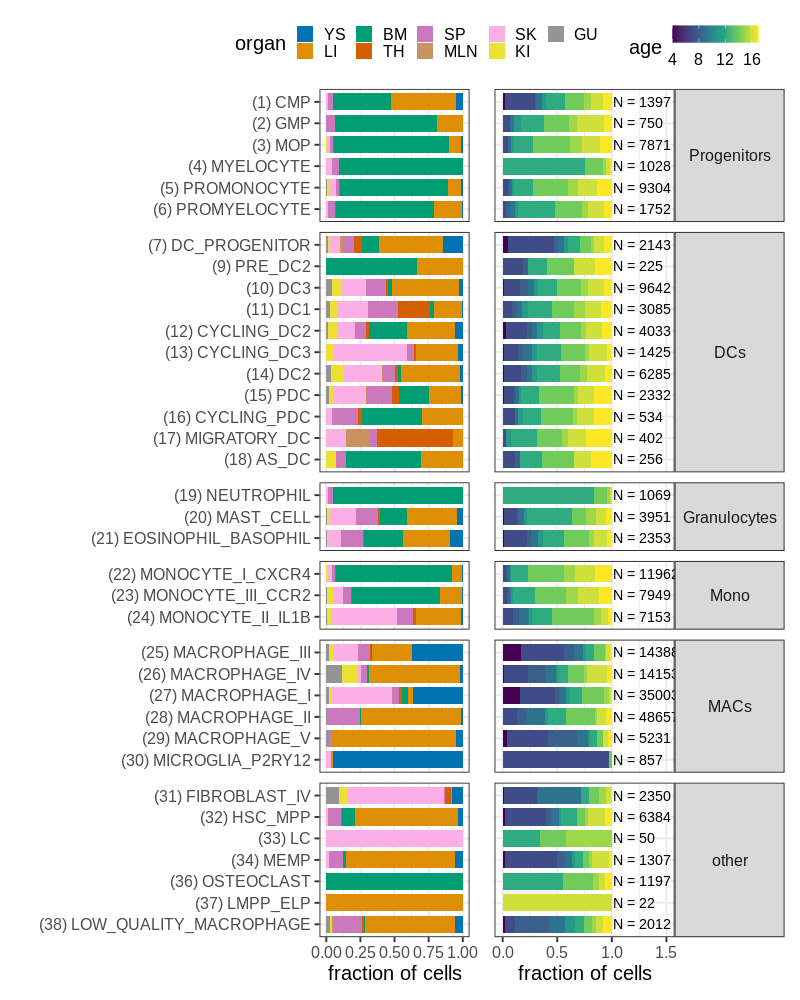

In [612]:
%%R -i age_count_df -i org_count_df -i figdir -i anno_group_order -i anno_order -i organ_order -w 800 -h 1000
library(glue)
anno_order_labels <- glue("({1:length(anno_order)}) {anno_order}")
anno_order_labels <- setNames(anno_order_labels, anno_order)

## Plot age barplot
age_pl_df <- age_count_df %>%
    rename(N_cells = file) %>%
    group_by(anno) %>%
    mutate(max_age = age[which.max(N_cells)])  %>% ## At which age there are most cells?
    mutate(min_age = min(age[which(N_cells > 10)]))  %>%
    ungroup() %>%
    arrange(- max_age) %>%
#     mutate(anno=factor(anno, levels=unique(anno))) %>%
    mutate(anno=anno_order_labels[anno]) %>%
    mutate(anno=factor(anno, levels=rev(anno_order_labels))) %>%
    mutate(anno_group = factor(anno_group, levels=anno_group_order))
    
p2 <- age_pl_df %>%
    filter(N_cells > 10) %>%
    ggplot(aes(anno, N_cells)) + 
    geom_col(aes(fill=age),position="fill", width=0.8) +
    coord_flip() +
    facet_grid(anno_group~., space="free", scales="free") +
    scale_fill_viridis_c() +
    theme_bw(base_size=20) +
    theme(strip.text.y=element_text(angle=0)) +
    ylab("fraction of cells") + xlab("") +
    expand_limits(y = 1.5) +
    geom_text(data=. %>% group_by(anno) %>% 
              summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
              hjust=0, size=5,
              y=1.01, aes(label=paste("N =", N_cells))
             ) 

## Plot organ barplot
org_palette <- setNames(org_colors$color, rownames(org_colors))
org_pl_df <- org_count_df %>%
    rename(N_cells = file) %>%
    mutate(anno=anno_order_labels[anno]) %>%
    mutate(anno=factor(anno, levels=levels(age_pl_df$anno))) %>%
    mutate(anno_group = factor(anno_group, levels=anno_group_order))

p1 <- org_pl_df %>%
    filter(N_cells > 10) %>%
    mutate(organ=factor(organ, levels=organ_order)) %>%
    ggplot(aes(anno, N_cells)) + 
    geom_col(aes(fill=organ) ,position="fill", width=0.8) +
    coord_flip() +
    facet_grid(anno_group~., space="free", scales="free") +
    scale_fill_manual(values=org_palette) +
    theme_bw(base_size=20) +
    theme(strip.text.y=element_text(angle=0)) +
    ylab("fraction of cells") + xlab("") +
    theme(strip.background=element_blank(), strip.text.y = element_blank())
#     geom_text(data=. %>% group_by(anno) %>% 
#               summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
#               hjust=0,
#               y=1.01, aes(label=paste("N =", N_cells))
#              ) +

fig2_lym_barplots <- (p1 + (p2 + remove_y_axis())) +
plot_layout(widths=c(1,1.2), guides="collect") &
# (guides(fill = guide_colourbar(title.position="top", title.hjust = 0.5))) &
(theme(legend.position="top"))

fig2_lym_barplots +
    ggsave(paste0(figdir, "mye_organ_age_distribution.pdf"), height=12, width=15) +
    ggsave(paste0(figdir, "mye_organ_age_distribution.png"), height=12, width=15) 

### Milo in time beeswarm plot

In [613]:
mye_milo_time.anno_group = [anno_group_rev[x] if x in anno_order else 'NA' for x in mye_milo_time.nhood_anno]

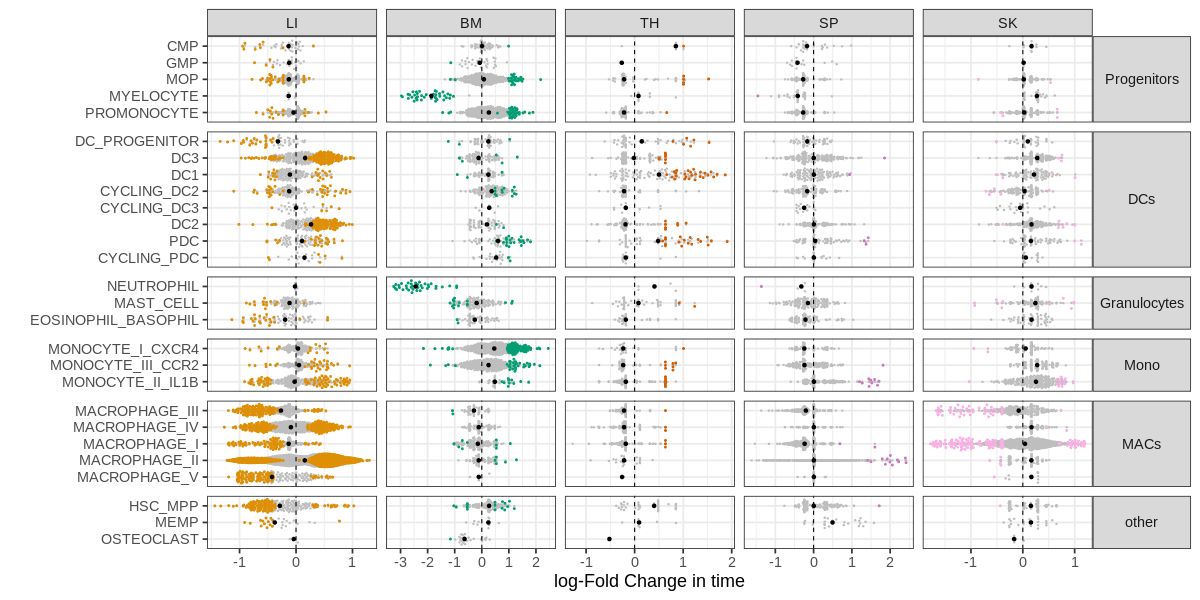

In [614]:
%%R -w 1200 -h 600 -i figdir -i mye_milo_time
library(ggbeeswarm)
alpha=0.1
set.seed(12345)

pl_df <- mye_milo_time %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    arrange(- mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=rev(anno_order))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    mutate(organ=factor(organ, levels=organ_order)) %>%
    filter(!is.na(anno_group)) 

fig2_mye_beeswarm <- pl_df %>%
    mutate(organ_color=ifelse(SpatialFDR < alpha, as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC)) +
    geom_quasirandom(size=0.5, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.7, aes(color=organ_color)) +
    geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=org_palette) +
    scale_fill_manual(values=org_palette) +
    guides(color="none", fill="none") +
    geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=18) +
    xlab("") + ylab("log-Fold Change in time") +
    scale_y_continuous(breaks=seq(-3,3, by=1)) +
    theme(strip.text.y=element_text(angle=0))
    
fig2_mye_beeswarm
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=15, height=15) +
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)

In [615]:
org_age_range  = anno_obs[['organ', "age"]].drop_duplicates()

In [616]:
%%R -i org_age_range -w 1000 -h 200 -i organ_order
fig2_mye_agebar <- org_age_range %>%
    filter(organ %in% mye_milo_time$organ) %>%
    mutate(organ=factor(organ, levels=organ_order)) %>%
    group_by(organ) %>%
    mutate(max_age=paste0(max(age), " PCW"), 
           min_age=paste0(min(age), " PCW")) %>%
    mutate(y=1) %>%
    ggplot(aes( age, y, color=organ)) +
    geom_point(size=3) +
    geom_line(size=2) +
    geom_text(data=. %>% group_by(organ) %>% filter(age==min(age)), 
              aes(label=min_age), angle=45,
              vjust = 1.2, 
              hjust = 1.1, nudge_x = -0.05, color='black') +
    geom_text(data=. %>% group_by(organ) %>% filter(age==max(age)), 
              aes(label=max_age), angle=45,
              vjust = 1.2,  
              hjust = 1.1, nudge_x = -0.05, color='black') +
    facet_grid(.~organ) +
    scale_color_manual(values=org_palette) +
    theme_classic(base_size=18) +
     expand_limits(x = c(3,20)) +
    remove_y_axis() + remove_x_axis() + 
    guides(color='none') +
    xlab("") + ylab("log-Fold Change in time") +
    theme(strip.text.y=element_text(angle=0), axis.line=element_blank(), 
          strip.background=element_blank(), strip.text=element_blank())

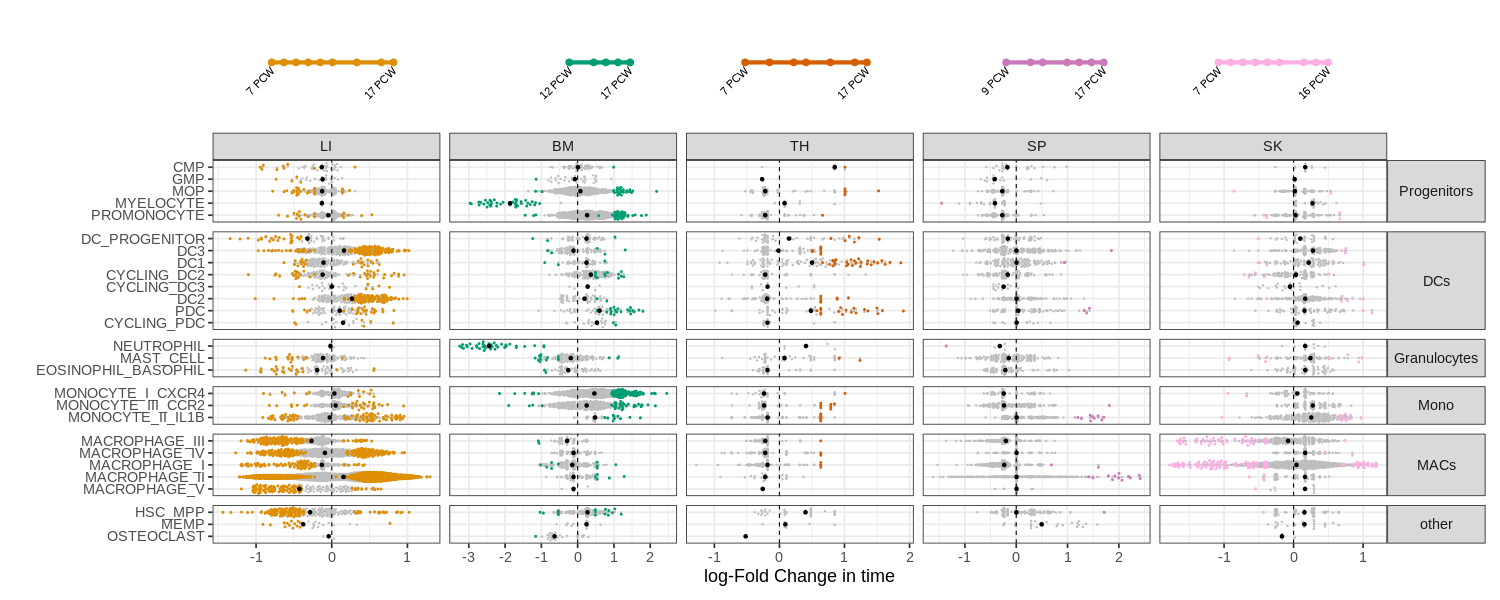

In [617]:
%%R -w 1500 -h 600
layout <- "
AAAAA
BBBBB
BBBBB
BBBBB
BBBBB
"

fig2_milo_age  <- fig2_mye_agebar + 
    fig2_mye_beeswarm +
    plot_layout(design=layout) 

fig2_milo_age +
ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=14, height=10) +
ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=14, height=10)


### Milo btw organs

In [618]:
mye_milo_organ.anno_group = [anno_group_rev[x] if x in anno_order else 'NA' for x in mye_milo_organ.nhood_anno]

In [619]:
%%R -i mye_milo_organ
library(ggrastr)
# plot_organ_FC_hm_group <- function(plot_df, g, logFC_limits = c(0,7)){

#     pl_df <- plot_df %>%
#         arrange(nhood_anno, hclust_order) %>%
#         mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
#         mutate(organ=factor(organ, levels=rev(organ_order))) %>%
#         mutate(nhood_anno=factor(nhood_anno, levels=rev(anno_order))) %>%
#         mutate(logFC = pmin(logFC, logFC_limits[2])) %>%
#         mutate(logFC = pmax(logFC, logFC_limits[1])) 


#     pl_df %>%
#         filter(anno_group==g) %>%
#         ggplot(aes(Nhood, organ,  fill=logFC)) +
#         geom_tile_rast() +
#         facet_grid(.~nhood_anno, scales='free', space="free") +
#         scale_fill_distiller(palette='Oranges', direction=1, limits=logFC_limits, name='Organ enrichment\n(logFC)') +
# #         scale_fill_viridis_c(option='magma', direction=1, limits=logFC_limits, name='Organ enrichment\n(logFC)') +
#         theme_classic(base_size=18) +
#         xlab("Neighbourhoods") +
#         remove_x_axis() +
#         theme(strip.background=element_rect(fill='grey', color=NA),
#               strip.text.y.left = element_text(angle = 0),
#               strip.text.x = element_text(angle = 0)
#               ) +
#         ggtitle(g)

# }

plot_organ_FC_hm_group <- function(plot_df, g, logFC_limits = c(0,7), layout_heights=c(1.5,4)){
    pl_df <- plot_df %>%
        arrange(nhood_anno, hclust_order) %>%
        mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
        mutate(organ=factor(organ, levels=rev(organ_order))) %>%
        mutate(nhood_anno=factor(nhood_anno, levels=anno_order)) %>%
        mutate(logFC = pmin(logFC, logFC_limits[2])) %>%
        mutate(logFC = pmax(logFC, logFC_limits[1])) 

    p1 <- pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood,nhood_anno)) +
        geom_tile_rast(fill='black') +
        facet_grid(.~nhood_anno, scales='free', space="free") +
        theme_classic(base_size=18) +
        remove_x_axis() +
        ylab("") +
        theme(axis.line.x=element_blank(), strip.background=element_blank(), strip.text=element_blank()) +
        ggtitle(g)

    p2 <- pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood,organ,  fill=logFC)) +
        geom_tile_rast() +
        facet_grid(.~nhood_anno, scales='free', space="free") +
#       scale_fill_gradient(low='#f7f7f7', high='#b2182b', limits=logFC_limits, name='Organ enrichment\n(logFC)') +
        scale_fill_distiller(palette='Reds', direction=1, limits=logFC_limits, name='Organ enrichment\n(logFC)') +
#         scale_fill_viridis_c(option='cividis', direction=-1, limits=logFC_limits, name='Organ enrichment\n(logFC)' )
        theme_classic(base_size=18) +
        xlab("Neighbourhood") +
        theme(strip.background=element_blank(), strip.text=element_blank(), 
              axis.line.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank()) 

    (p1 / p2 ) + plot_layout(heights=layout_heights, guides='collect')
    } 

# plot_organ_FC_hm_group(mye_milo_organ, "MACs")

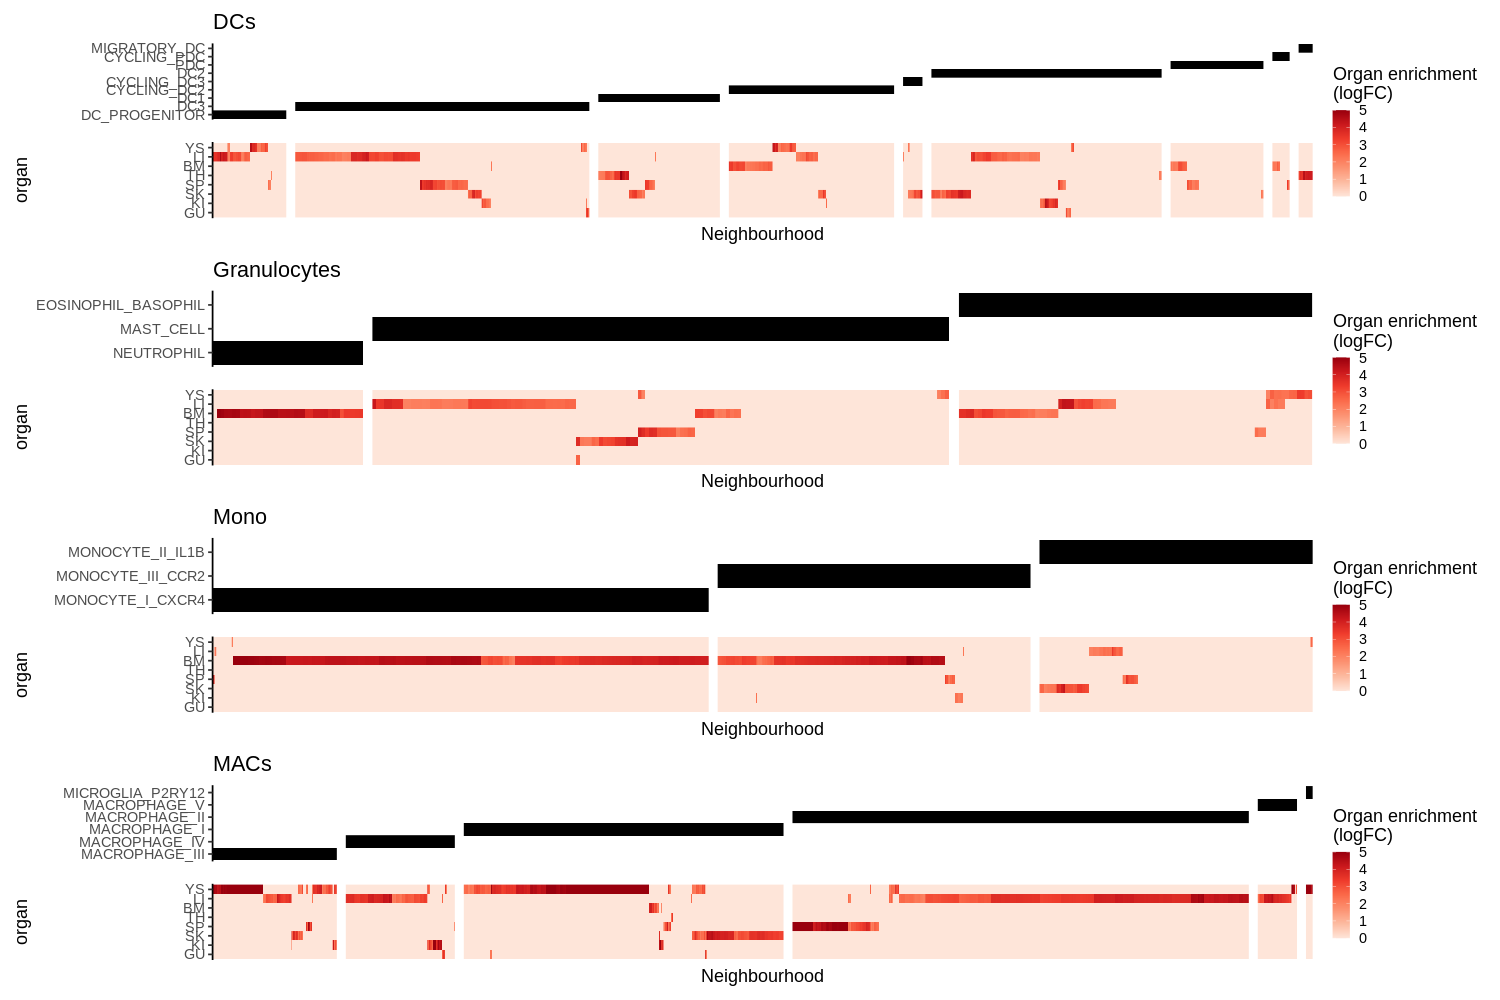

In [620]:
%%R -w 1500 -h 1000
pl_params <- list(
    gr=c('DCs', 'Granulocytes', 'Mono', 'MACs'),
    layout=c(c(2.5,4), c(1,4), c(1,4), c(2.5,4))
)
pl_ls <- lapply(1:4, function(g) plot_organ_FC_hm_group(mye_milo_organ, pl_params$gr[g], layout_heights = pl_params$layout[g], logFC_limits = c(0,5)))
wrap_plots(pl_ls, ncol=1, nrow=4) +
    plot_layout(guides='collect') +
    ggsave(paste0(figdir, "milo_organ_results_overview_heatmap.pdf"), width=15, height=16)

### Adult vs fetal

In [629]:
q_df = mye_adult_heatmap.copy()
q_df['predicted_anno_group'] = [anno_group_rev[x] if x in anno_order else 'low_confidence' if x=='low_confidence' else 'NA' for x in q_df['predicted_anno']]
q_df

,mnn_sim_ratio,predicted_anno,annotation_query,organ code,annotation_query_group,predicted_anno_group
Pan_T7935490_AACCATGTCTCGTTTA-query,0.938455,MACROPHAGE_III,Cycling macrophages,ILE,MACs,MACs
Pan_T7935490_CGTAGGCCAATGGACG-query,0.610085,MACROPHAGE_IV,Red pulp macrophages,ILE,MACs,MACs
Pan_T7935490_CGTCAGGCAGGGATTG-query,0.860658,MACROPHAGE_II,Red pulp macrophages,ILE,MACs,MACs
Pan_T7935490_CTACACCAGCGCTCCA-query,0.980483,DC2,DC2,ILE,DCs,DCs
Pan_T7935490_CTCGAAAAGCGATATA-query,0.969986,LOW_QUALITY_MACROPHAGE,DC2,ILE,DCs,other
...,...,...,...,...,...,...
Pan_T8986831_TTCTCCTAGCGTGAGT-query,0.748570,MONOCYTE_II_IL1B,Lung macrophages (IV),LNG,MACs,Mono
Pan_T8986831_TTCTCCTTCAACGAAA-query,0.030950,MONOCYTE_II_IL1B,Lung macrophages (IV),LNG,MACs,Mono
Pan_T8986831_TTCTTAGAGTGTGGCA-query,0.031469,low_confidence,Lung macrophages (I),LNG,MACs,low_confidence
Pan_T8986831_TTGCCGTTCGGCCGAT-query,0.302785,MACROPHAGE_I,Lung macrophages (IV),LNG,MACs,MACs


`summarise()` has grouped output by 'predicted_anno', 'annotation_query', 'annotation_query_group', 'predicted_anno_group'. You can override using the `.groups` argument.


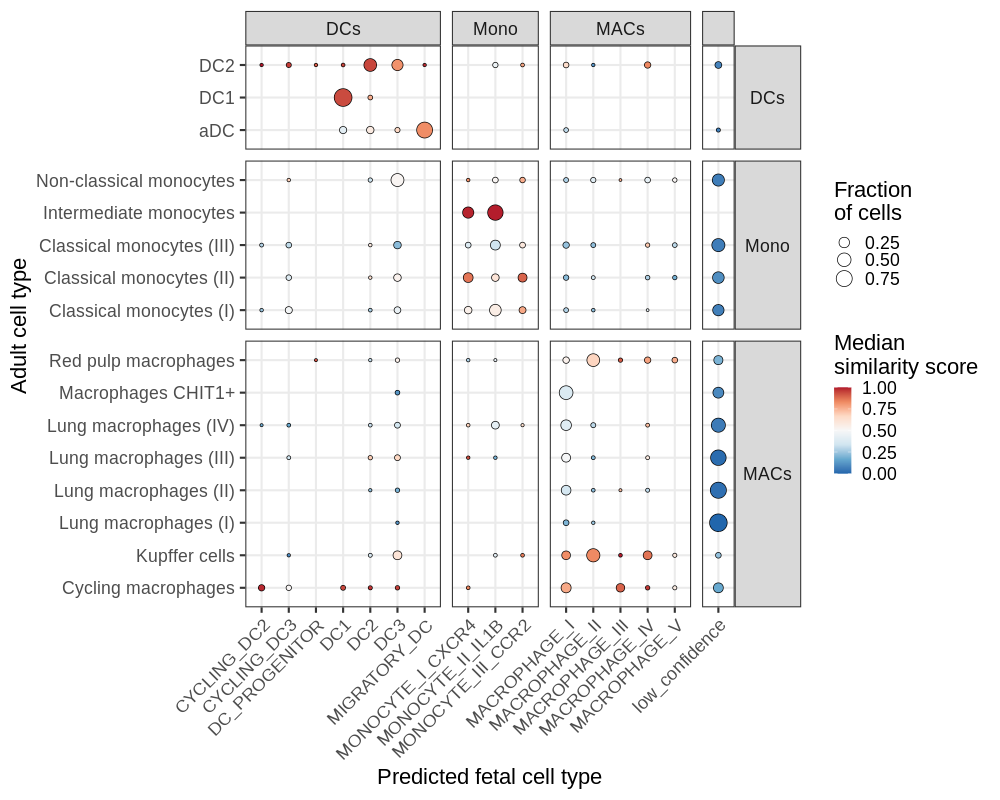

In [630]:
%%R -i q_df -h 800 -w 1000 -i figdir
q_df %>%
    group_by(annotation_query) %>%
    mutate(tot_cells=n()) %>%
    ungroup() %>%
    group_by(predicted_anno, annotation_query, annotation_query_group, predicted_anno_group) %>%
    summarise(frac_cells=n()/tot_cells, median_sim_score=median(mnn_sim_ratio)) %>%
    ungroup() %>%
    filter(annotation_query_group != 'other' & predicted_anno_group != 'other' & predicted_anno_group != 'NA') %>%
    mutate(annotation_query_group=factor(annotation_query_group, levels=c(anno_group_order, 'low_confidence'))) %>%
    mutate(predicted_anno_group = ifelse(predicted_anno_group=="low_confidence", '', predicted_anno_group)) %>%
    mutate(predicted_anno_group=factor(predicted_anno_group, levels=c(anno_group_order, ''))) %>%
    filter(predicted_anno_group %in% c("Mono", 'MACs', "DCs","")) %>%
        distinct() %>%
    ggplot(aes(predicted_anno, annotation_query)) +
    scale_size(range=c(1,8), name="Fraction\nof cells") +
    geom_point(aes(size=frac_cells, fill=median_sim_score), shape=21) +
    scale_fill_distiller(palette="RdBu", direction=-1, name='Median\nsimilarity score') +
    facet_grid(annotation_query_group~predicted_anno_group, space="free", scales='free') +
    xlab("Predicted fetal cell type") + ylab("Adult cell type") +
    theme_bw(base_size=22) +
#     guides(fill = guide_colourbar(title.position="top", title.hjust = 0.5, barwidth = 15),
#           size = guide_legend(title.position="top", title.hjust = 0.5)) +
    theme(axis.text.x=element_text(angle=45, hjust=1),
                    strip.text.y=element_text(angle=0),
#           legend.position="top"
         ) +
    ggsave(paste0(figdir, "adult_confusion_similarity_dotplot.pdf"), width=14, height=9)

---
## Lymphoid

### Embedding

In [631]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"
split="LYMPHOID"

In [632]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"

In [633]:
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split), backed="r")
adata.var_names_make_unique()

In [634]:
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
anno_obs_lym = anno_obs.loc[adata.obs_names[adata.obs_names.isin(anno_obs.index)]].copy()

In [635]:
anno_obs = anno_obs_lym.copy()
anno_group = anno_group_lymphoid.copy()
anno_group_rev = anno_group_lymphoid_rev.copy()

org_count_df = anno_obs_lym.groupby(["organ", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
org_count_df["anno_group"] = [anno_group_rev[x] if x in anno_group_rev.keys() else np.nan for x in org_count_df.anno_lvl_2_final_clean]
org_count_df["anno"] = org_count_df["anno_lvl_2_final_clean"]

age_count_df = anno_obs_lym.groupby(["age", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
age_count_df["anno_group"] = [anno_group_rev[x] if x in anno_group_rev.keys() else np.nan for x in age_count_df.anno_lvl_2_final_clean]
age_count_df["anno"] = age_count_df["anno_lvl_2_final_clean"]

anno_group_order = list(anno_group.keys())
anno_order = sum([v for v in anno_group.values()],[])

In [636]:
adata.obs['anno_lvl_2_final_clean'] = np.nan
adata.obs.loc[adata.obs_names.isin(anno_obs_lym.index), 'anno_lvl_2_final_clean'] = anno_obs_lym.loc[adata.obs_names[adata.obs_names.isin(anno_obs_lym.index)]]['anno_lvl_2_final_clean']

In [637]:
anno_numbering = {anno_order[i]:str(i+1) for i in range(len(anno_order))}
adata.obs['anno_number'] = [anno_numbering[x] if x in anno_order else np.nan for x in adata.obs['anno_lvl_2_final_clean']]

saving figure to file /home/jovyan/mount/gdrive/Pan_fetal/writing/ms_figures/draft_panels/assemble_fig2/scvelo_LYMPHOID_annotation_embedding.png


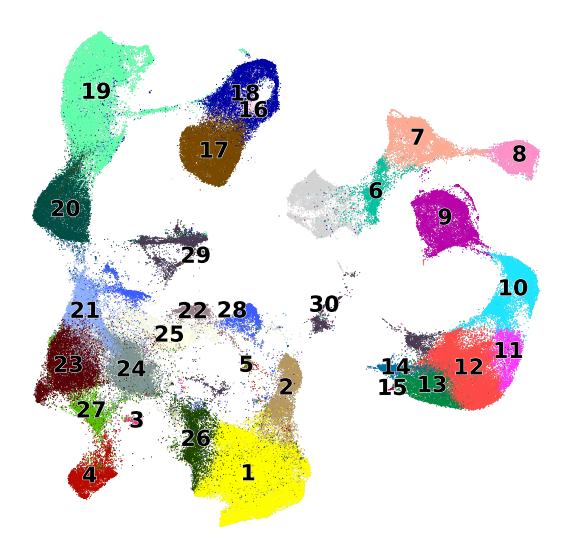

In [638]:
plt.rcParams['figure.figsize'] = [10,10]
scv.pl.umap(adata, color=['anno_number'], 
            title="", legend_fontsize=22, size=5,
#             groups=,
            save='LYMPHOID_annotation_embedding.png'
           )

Make legend

In [639]:
color_dict = dict(zip(adata.obs['anno_number'].cat.categories, adata.uns['anno_number_colors']))
anno_order_labels = ["({n}) {a}".format(n=str(i+1),a=anno_order[i]) for i in range(len(anno_order))]
anno_number = ["{n}".format(n=str(i+1)) for i in range(len(anno_order))]

anno_order_df = pd.DataFrame([anno_order_labels, anno_order]).T
anno_order_df.columns = ['anno_order_labels', 'anno_lvl_2_final_clean']
anno_order_df['anno_number'] = [anno_numbering[x] for x in anno_order_df['anno_lvl_2_final_clean']]
anno_order_df['anno_color'] = [color_dict[x] for x in anno_order_df['anno_number']]
anno_order_df['anno_group'] = [anno_group_lymphoid_rev[x] for x in anno_order_df['anno_lvl_2_final_clean']]

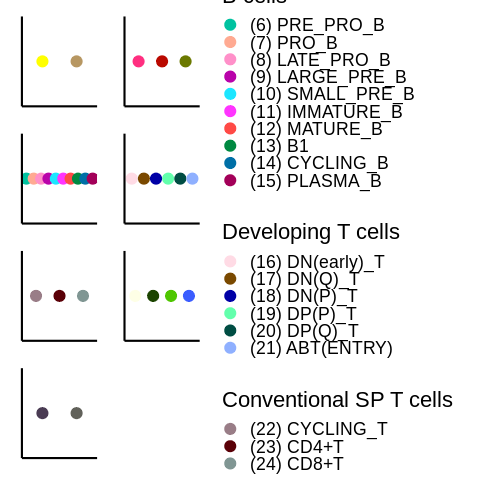

In [640]:
%%R -i anno_order_df 
library(ggpubr)
anno_order_df$anno_order_labels <- factor(anno_order_df$anno_order_labels, levels=anno_order_df$anno_order_labels)
leg_ls <- lapply(unique(anno_order_df$anno_group), function(g) {
    pl <- anno_order_df %>%
    filter(anno_group==g) %>%
    ggplot(aes(anno_order_labels, 1, color=anno_order_labels)) +
    geom_point(size=5) +
    theme_classic(base_size=22) +
    remove_x_axis() +
    remove_y_axis() +
    scale_color_manual(values=setNames(anno_order_df$anno_color, anno_order_df$anno_order_labels),
                      name=g)
#     leg <- get_legend(pl)
#     leg
    pl
    }
)

(wrap_plots(leg_ls, ncol=2) +
plot_layout(guides='collect') & 
theme(legend.justification = "left") &
guides(color=guide_legend(ncol = 1))) +
ggsave(paste0(figdir, "lym_embedding_legend.pdf"), height=14, width=12)

### Organ / age distribution

In [641]:
anno_obs = anno_obs_lym.copy()
anno_group = anno_group_lymphoid.copy()
anno_group_rev = anno_group_lymphoid_rev.copy()

org_count_df = anno_obs_lym.groupby(["organ", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
org_count_df["anno_group"] = [anno_group_rev[x] if x in anno_group_rev.keys() else np.nan for x in org_count_df.anno_lvl_2_final_clean]
org_count_df["anno"] = org_count_df["anno_lvl_2_final_clean"]

age_count_df = anno_obs_lym.groupby(["age", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
age_count_df["anno_group"] = [anno_group_rev[x] if x in anno_group_rev.keys() else np.nan for x in age_count_df.anno_lvl_2_final_clean]
age_count_df["anno"] = age_count_df["anno_lvl_2_final_clean"]

anno_group_order = list(anno_group.keys())
anno_order = sum([v for v in anno_group.values()],[])
org_count_df

,organ,anno_lvl_2_final_clean,file,anno_group,anno
0,BM,ABT(ENTRY),2,Developing T cells,ABT(ENTRY)
1,BM,B1,97,B cells,B1
2,BM,CD4+T,255,Conventional SP T cells,CD4+T
3,BM,CD8+T,126,Conventional SP T cells,CD8+T
4,BM,CD8AA,15,Unconventional T cells,CD8AA
...,...,...,...,...,...
373,YS,NK_T,3,Unconventional T cells,NK_T
374,YS,PDC,18,NaN,PDC
375,YS,PRE_DC2,2,NaN,PRE_DC2
376,YS,PRE_PRO_B,50,B cells,PRE_PRO_B


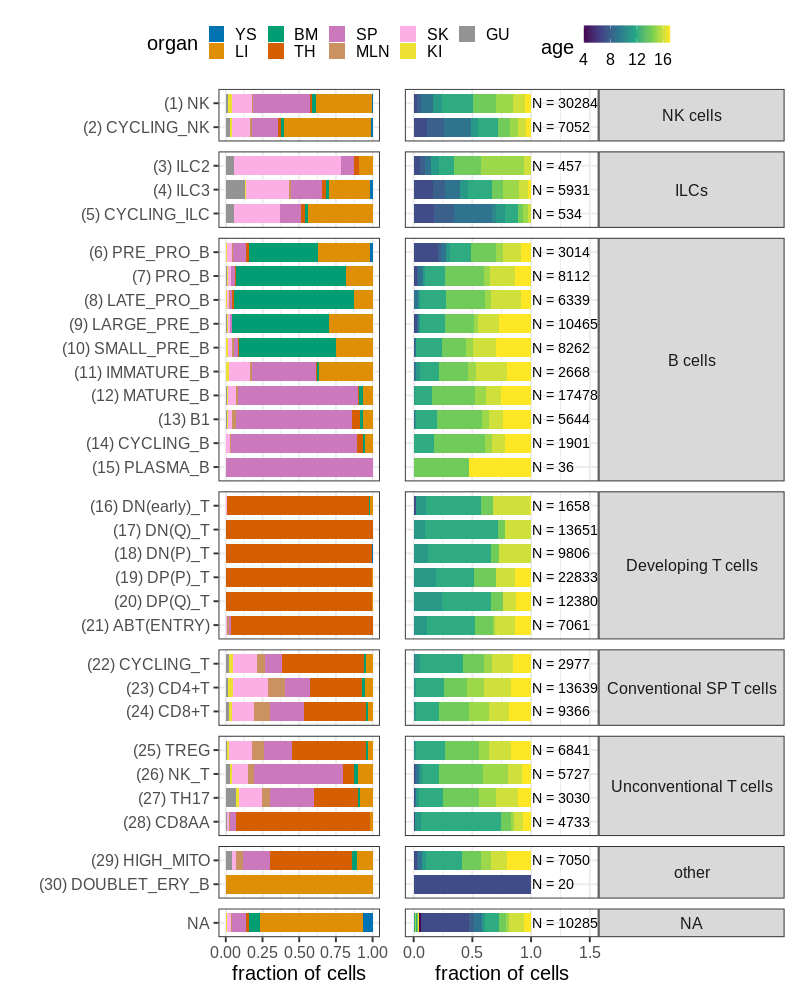

In [642]:
%%R -i age_count_df -i org_count_df -i figdir -i anno_group_order -i anno_order -i organ_order -w 800 -h 1000
library(glue)
anno_order_labels <- glue("({1:length(anno_order)}) {anno_order}")
anno_order_labels <- setNames(anno_order_labels, anno_order)

## Plot age barplot
age_pl_df <- age_count_df %>%
    rename(N_cells = file) %>%
    group_by(anno) %>%
    mutate(max_age = age[which.max(N_cells)])  %>% ## At which age there are most cells?
    mutate(min_age = min(age[which(N_cells > 10)]))  %>%
    ungroup() %>%
    arrange(- max_age) %>%
#     mutate(anno=factor(anno, levels=unique(anno))) %>%
    mutate(anno=anno_order_labels[anno]) %>%
    mutate(anno=factor(anno, levels=rev(anno_order_labels))) %>%
    mutate(anno_group = factor(anno_group, levels=anno_group_order))
    
p2 <- age_pl_df %>%
    filter(N_cells > 10) %>%
    ggplot(aes(anno, N_cells)) + 
    geom_col(aes(fill=age),position="fill", width=0.8) +
    coord_flip() +
    facet_grid(anno_group~., space="free", scales="free") +
    scale_fill_viridis_c() +
    theme_bw(base_size=20) +
    theme(strip.text.y=element_text(angle=0)) +
    ylab("fraction of cells") + xlab("") +
    expand_limits(y = 1.5) +
    geom_text(data=. %>% group_by(anno) %>% 
              summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
              hjust=0, size=5,
              y=1.01, aes(label=paste("N =", N_cells))
             ) 

## Plot organ barplot
org_palette <- setNames(org_colors$color, rownames(org_colors))
org_pl_df <- org_count_df %>%
    rename(N_cells = file) %>%
    mutate(anno=anno_order_labels[anno]) %>%
    mutate(anno=factor(anno, levels=levels(age_pl_df$anno))) %>%
    mutate(anno_group = factor(anno_group, levels=anno_group_order))

p1 <- org_pl_df %>%
    filter(N_cells > 10) %>%
    mutate(organ=factor(organ, levels=organ_order)) %>%
    ggplot(aes(anno, N_cells)) + 
    geom_col(aes(fill=organ) ,position="fill", width=0.8) +
    coord_flip() +
    facet_grid(anno_group~., space="free", scales="free") +
    scale_fill_manual(values=org_palette) +
    theme_bw(base_size=20) +
    theme(strip.text.y=element_text(angle=0)) +
    ylab("fraction of cells") + xlab("") +
    theme(strip.background=element_blank(), strip.text.y = element_blank())
#     geom_text(data=. %>% group_by(anno) %>% 
#               summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
#               hjust=0,
#               y=1.01, aes(label=paste("N =", N_cells))
#              ) +

fig2_lym_barplots <- (p1 + (p2 + remove_y_axis())) +
plot_layout(widths=c(1,1.2), guides="collect") &
# (guides(fill = guide_colourbar(title.position="top", title.hjust = 0.5))) &
(theme(legend.position="top"))

fig2_lym_barplots +
    ggsave(paste0(figdir, "lym_organ_age_distribution.pdf"), height=12, width=12) +
    ggsave(paste0(figdir, "lym_organ_age_distribution.png"), height=12, width=12) 

### Milo in time beeswarm plot

In [643]:
lym_milo_time.anno_group = [anno_group_rev[x] if x in anno_order else 'NA' for x in lym_milo_time.nhood_anno]

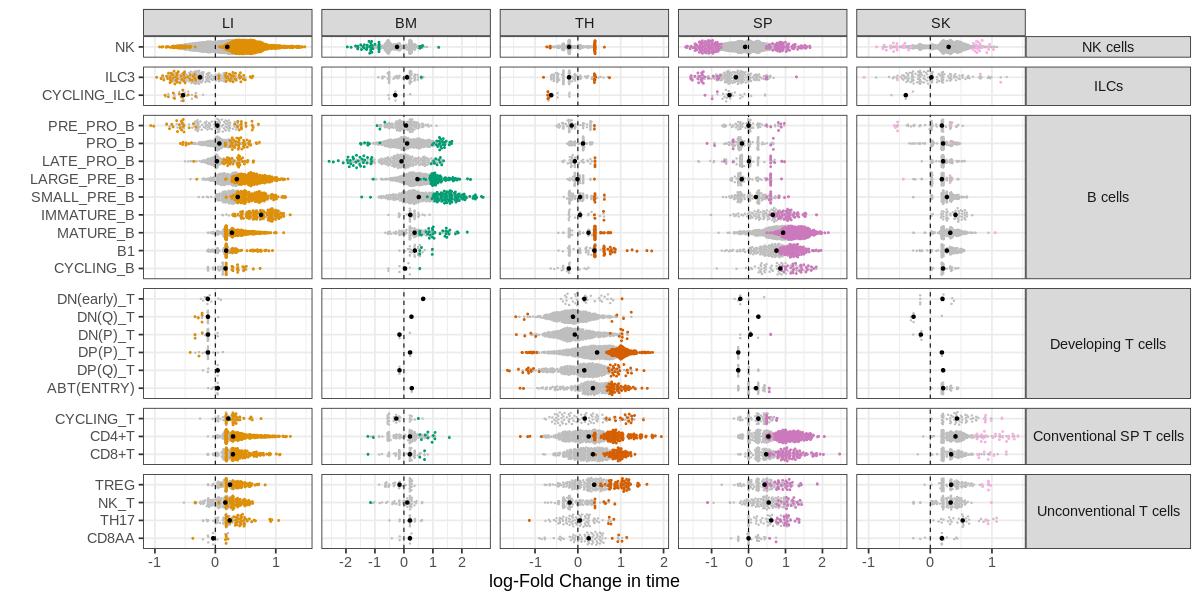

In [644]:
%%R -w 1200 -h 600 -i figdir -i lym_milo_time
library(ggbeeswarm)
alpha=0.1
set.seed(12345)

pl_df <- lym_milo_time %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    arrange(- mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=rev(anno_order))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    mutate(organ=factor(organ, levels=organ_order)) %>%
    filter(!is.na(anno_group)) 

fig2_lym_beeswarm <- pl_df %>%
    mutate(organ_color=ifelse(SpatialFDR < alpha, as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC)) +
    geom_quasirandom(size=0.5, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.7, aes(color=organ_color)) +
    geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=org_palette) +
    scale_fill_manual(values=org_palette) +
    guides(color="none", fill="none") +
    geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=18) +
    xlab("") + ylab("log-Fold Change in time") +
    scale_y_continuous(breaks=seq(-3,3, by=1)) +
    theme(strip.text.y=element_text(angle=0))
    
fig2_lym_beeswarm
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=15, height=15) +
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)

In [645]:
org_age_range  = anno_obs[['organ', "age"]].drop_duplicates()

In [646]:
%%R -i org_age_range -w 1000 -h 200 -i organ_order
fig2_lym_agebar <- org_age_range %>%
    filter(organ %in% mye_milo_time$organ) %>%
    mutate(organ=factor(organ, levels=organ_order)) %>%
    group_by(organ) %>%
    mutate(max_age=paste0(max(age), " PCW"), 
           min_age=paste0(min(age), " PCW")) %>%
    mutate(y=1) %>%
    ggplot(aes( age, y, color=organ)) +
    geom_point(size=3) +
    geom_line(size=2) +
    geom_text(data=. %>% group_by(organ) %>% filter(age==min(age)), 
              aes(label=min_age), angle=45,
              vjust = 1.2, 
              hjust = 1.1, nudge_x = -0.05, color='black') +
    geom_text(data=. %>% group_by(organ) %>% filter(age==max(age)), 
              aes(label=max_age), angle=45,
              vjust = 1.2,  
              hjust = 1.1, nudge_x = -0.05, color='black') +
    facet_grid(.~organ) +
    scale_color_manual(values=org_palette) +
    theme_classic(base_size=18) +
     expand_limits(x = c(3,20)) +
    remove_y_axis() + remove_x_axis() + 
    guides(color='none') +
    xlab("") + ylab("log-Fold Change in time") +
    theme(strip.text.y=element_text(angle=0), axis.line=element_blank(), 
          strip.background=element_blank(), strip.text=element_blank())

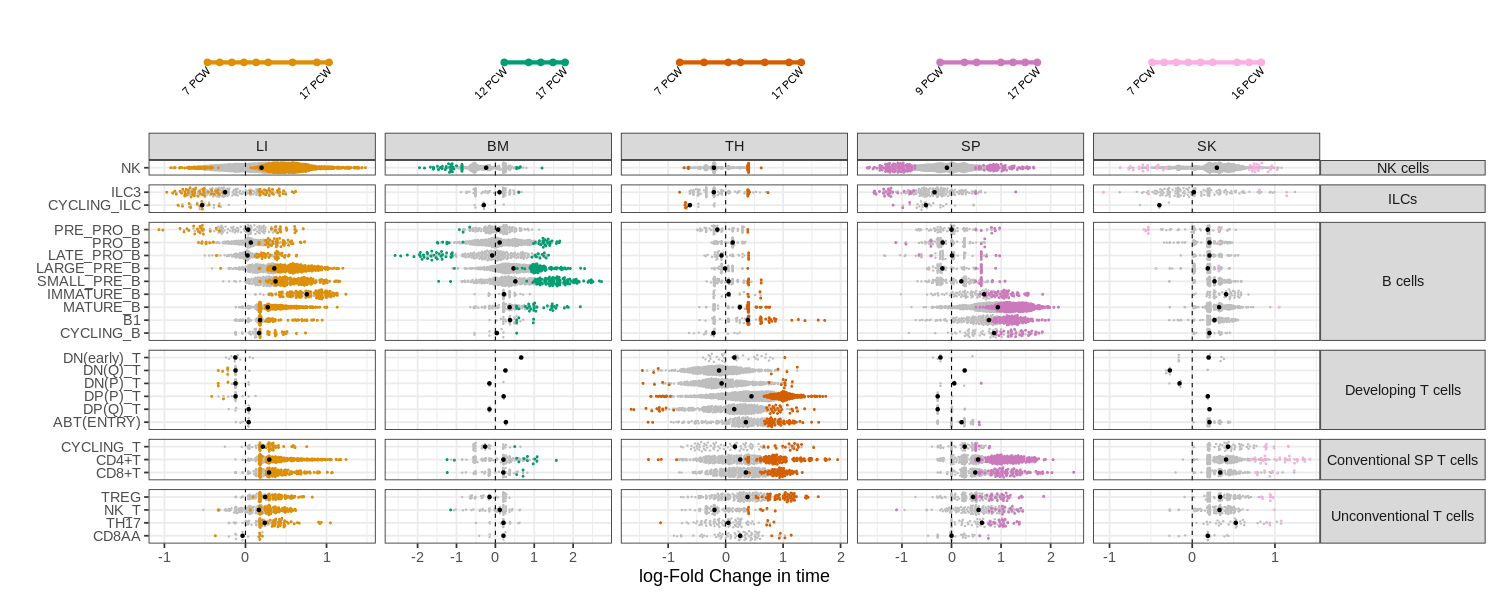

In [647]:
%%R -w 1500 -h 600
layout <- "
AAAAA
BBBBB
BBBBB
BBBBB
BBBBB
"

fig2_milo_age  <- fig2_lym_agebar + 
    fig2_lym_beeswarm +
    plot_layout(design=layout) 

fig2_milo_age +
ggsave(paste0(figdir, "milo_results_overview_beeswarm_lymphoid.pdf"), width=14, height=10) 


### Milo btw organs

In [648]:
lym_milo_organ.anno_group = [anno_group_rev[x] if x in anno_order else 'NA' for x in lym_milo_organ.nhood_anno]
lym_milo_organ['anno_group'] = ["T cells" if x in ['Conventional SP T cells','Unconventional T cells', "Developing T cells"] else x for x in lym_milo_organ['anno_group']]
lym_milo_organ

,Nhood,nhood_anno,anno_group,hclust_order,organ,logFC,SpatialFDR
1,1,CD4+T,T cells,420.0,SK,2.972581,4.769811e-02
2,1,CD4+T,T cells,420.0,SP,0.000000,9.767437e-01
3,1,CD4+T,T cells,420.0,YS,0.000000,3.131578e-01
4,1,CD4+T,T cells,420.0,LI,0.000000,5.931861e-03
5,1,CD4+T,T cells,420.0,TH,0.000000,5.224552e-01
...,...,...,...,...,...,...,...
78180,10001,ABT(ENTRY),T cells,264.0,LI,0.000000,4.753251e-09
78181,10001,ABT(ENTRY),T cells,264.0,TH,4.496291,1.225885e-33
78182,10001,ABT(ENTRY),T cells,264.0,GU,0.000000,1.258124e-01
78183,10001,ABT(ENTRY),T cells,264.0,BM,0.000000,8.023439e-07


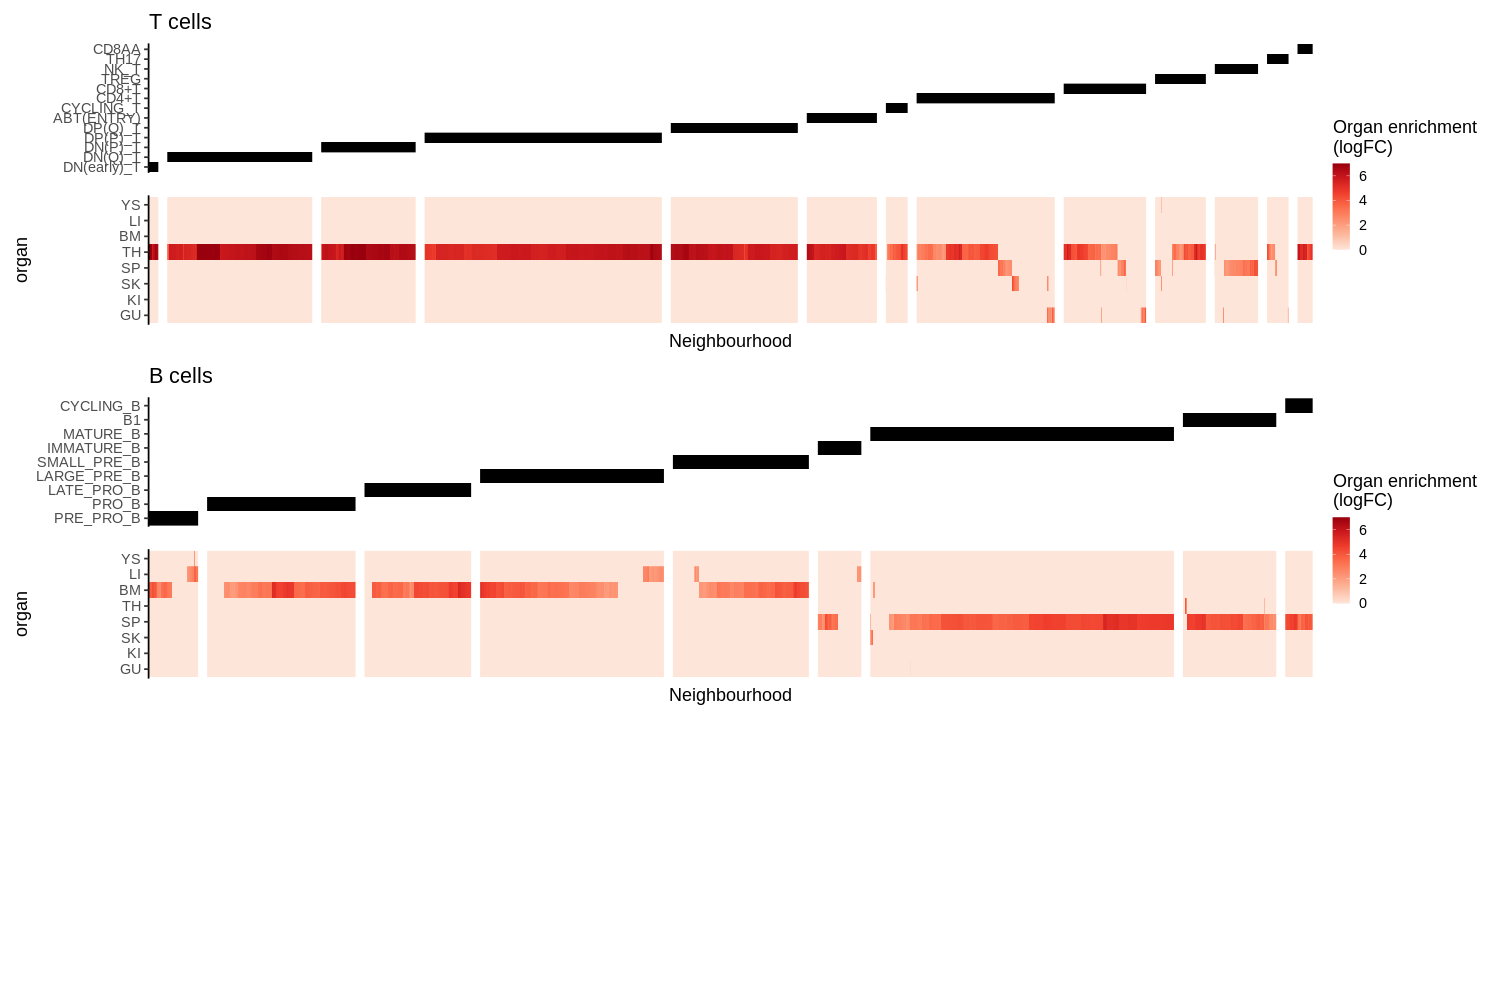

In [649]:
%%R -w 1500 -h 1000 -i lym_milo_organ
pl_params <- list(
    gr=c('T cells',"B cells"),
    layout=c(c(3,4), c(2,4))
)
pl_ls <- lapply(1:2, function(g) plot_organ_FC_hm_group(lym_milo_organ, pl_params$gr[g], layout_heights = pl_params$layout[g]))

# layout <- "
# AAAAAA
# BBBCCC
# DDDDDD
# "

wrap_plots(pl_ls, ncol=1, nrow=3) +
    plot_layout(guides='collect', 
# #                 design=layout
               ) +
    ggsave(paste0(figdir, "milo_organ_results_overview_heatmap_lym.pdf"), width=15, height=16)

### Adult vs fetal

In [650]:
q_df = lym_adult_heatmap.copy()

query_anno_group_lymphoid = {
    "B cells":[x for x in q_df.annotation_query.unique() if x.endswith("B") or "GC_B" in x or x=="B_prog" or "Plasma" in x or 'MemB' in x],
    "NK cells":[x for x in q_df.annotation_query.unique() if x.startswith("NK")],
    "Unconventional T cells":["Tfh", "Tregs", "MAIT"],
    "other":[x for x in q_df.annotation_query.unique() if 'doublets' in x],
    }

query_anno_group_lymphoid['Conventional T cells'] = [x for x in q_df.annotation_query.unique() if x not in sum(query_anno_group_lymphoid.values(),[])]
query_anno_group_lymphoid_rev = {x:g for g,a in query_anno_group_lymphoid.items() for x in a}

q_df['annotation_query_group'] = [query_anno_group_lymphoid_rev[x] for x in q_df['annotation_query']]
q_df['predicted_anno_group'] = [anno_group_rev[x] if x in anno_order else 'low_confidence' if x=='low_confidence' else 'NA' for x in q_df['predicted_anno']]
q_df

,mnn_sim_ratio,predicted_anno,annotation_query,organ code,annotation_query_group,predicted_anno_group
Pan_T7935490_AAACCTGCAAATTGCC-query,0.325178,low_confidence,MAIT,ILE,Unconventional T cells,low_confidence
Pan_T7935490_AAACGGGCATCTGGTA-query,0.146242,low_confidence,Cytotoxic_CD8_CCR9,ILE,Conventional T cells,low_confidence
Pan_T7935490_AAACGGGTCTTGCATT-query,0.470773,NK_T,Cytotoxic_CD8_CCR9,ILE,Conventional T cells,Unconventional T cells
Pan_T7935490_AAAGCAATCATCGCTC-query,0.000000,low_confidence,Cytotoxic_CD8_CCR9,ILE,Conventional T cells,low_confidence
Pan_T7935490_AAAGTAGCAGTCACTA-query,0.372246,HIGH_MITO,Cytotoxic_CD8_CCR9,ILE,Conventional T cells,other
...,...,...,...,...,...,...
Pan_T8986831_TTCTACAAGCCTCGTG-query,0.772299,low_confidence,NK_CD16hi,LNG,NK cells,low_confidence
Pan_T8986831_TTGACTTGTATATGGA-query,0.891146,NK_T,Cytotoxic_CD8_CRTAM,LNG,Conventional T cells,Unconventional T cells
Pan_T8986831_TTGCCGTTCAGCAACT-query,0.319199,TREG,Cytotoxic_T,LNG,Conventional T cells,Unconventional T cells
Pan_T8986831_TTGGAACTCTTCAACT-query,0.905818,NK,NK_CD16hi,LNG,NK cells,NK cells


`summarise()` has grouped output by 'predicted_anno', 'annotation_query', 'annotation_query_group', 'predicted_anno_group'. You can override using the `.groups` argument.


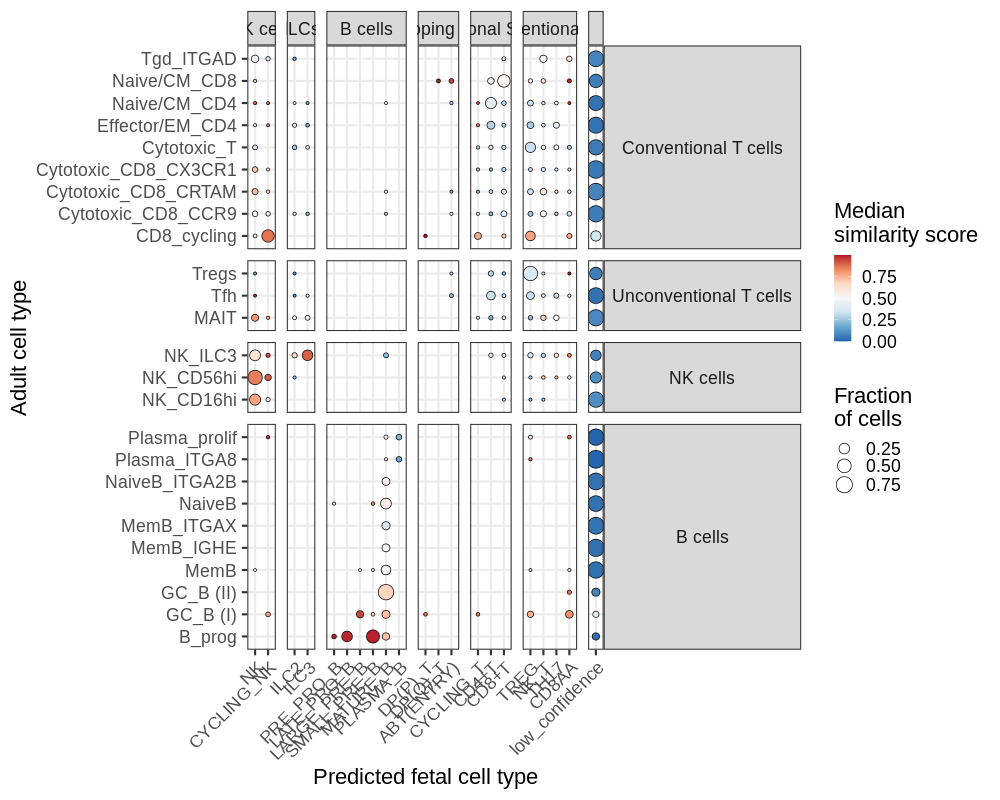

In [651]:
%%R -i q_df -h 800 -w 1000 -i figdir -i anno_order -i anno_group_order
q_df %>%
    group_by(annotation_query) %>%
    mutate(tot_cells=n()) %>%
    ungroup() %>%
    group_by(predicted_anno, annotation_query, annotation_query_group, predicted_anno_group) %>%
    summarise(frac_cells=n()/tot_cells, median_sim_score=median(mnn_sim_ratio)) %>%
    ungroup() %>%
    filter(annotation_query_group != 'other' & predicted_anno_group != 'other' & predicted_anno_group != 'NA') %>%
    mutate(annotation_query_group=factor(annotation_query_group, levels=unique(annotation_query_group))) %>%
    mutate(predicted_anno_group = ifelse(predicted_anno_group=="low_confidence", '', predicted_anno_group)) %>%
    mutate(predicted_anno_group=factor(predicted_anno_group, levels=c(anno_group_order, ''))) %>%
    mutate(predicted_anno=factor(predicted_anno, levels=c(anno_order, 'low_confidence'))) %>%
    distinct() %>%
#     filter(predicted_anno_group %in% c("Mono", 'MACs', "DCs","")) %>%
    ggplot(aes(predicted_anno, annotation_query)) +
    scale_size(range=c(1,8), name="Fraction\nof cells") +
    geom_point(aes(size=frac_cells, fill=median_sim_score), shape=21) +
    scale_fill_distiller(palette="RdBu", direction=-1, name='Median\nsimilarity score') +
    facet_grid(annotation_query_group~predicted_anno_group, space="free", scales='free') +
    xlab("Predicted fetal cell type") + ylab("Adult cell type") +
    theme_bw(base_size=22) +
#     guides(fill = guide_colourbar(title.position="top", title.hjust = 0.5, barwidth = 15),
#           size = guide_legend(title.position="top", title.hjust = 0.5)) +
    theme(axis.text.x=element_text(angle=45, hjust=1),
          strip.text.y=element_text(angle=0),
#           legend.position="top"
         ) +
    ggsave(paste0(figdir, "adult_confusion_similarity_dotplot_lym.pdf"), width=20, height=10)

### Embedding

In [277]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"
split="LYMPHOID"

In [299]:
outdir = '/nfs/team205/ed6/data/Fetal_immune/milo_outs/{s}/'.format(s=split)
adata = sc.read_h5ad(outdir + "adata4milo.{s}.h5ad".format(s=split), backed="r")

anno_numbering = {anno_order[i]:str(i+1) for i in range(len(anno_order))}

adata.obs['anno_number'] = [anno_numbering[x] if x in anno_order else np.nan for x in adata.obs['anno_lvl_2_final_clean']]

plt.rcParams['figure.figsize'] = [10,10]
scv.pl.umap(adata, color=['anno_number'], 
            title="", legend_fontsize=22, size=5,
#             groups=anno_order,
            save='LYMPHOID_V2_annotation_embedding.png'
           )

---

In [655]:
tcells = lym_milo_time[lym_milo_time.nhood_anno.isin(['NK_T', 'TH17', "CD4+T", "CD8+T"])]

,Nhood,nhood_anno,anno_group,organ,logFC,SpatialFDR,mean_logFC
3422,752,CD4+T,Conventional SP T cells,SP,2.048913,9.452157e-04,0.536927
3423,4981,CD4+T,Conventional SP T cells,TH,1.949152,1.551501e-08,0.253669
3424,7080,CD4+T,Conventional SP T cells,SP,1.893841,8.485031e-04,0.536927
3425,6982,CD4+T,Conventional SP T cells,SP,1.868428,1.014908e-04,0.536927
3426,5041,CD4+T,Conventional SP T cells,TH,1.808253,1.332840e-05,0.253669
...,...,...,...,...,...,...,...
10640,923,NK_T,Unconventional T cells,SP,-0.947513,2.077853e-01,0.544985
10641,3689,NK_T,Unconventional T cells,BM,-1.020901,2.013826e-01,0.115448
10642,3676,NK_T,Unconventional T cells,BM,-1.069077,2.082984e-01,0.115448
10643,9197,NK_T,Unconventional T cells,SP,-1.108689,7.428717e-02,0.544985


`summarise()` has grouped output by 'Nhood', 'anno_group'. You can override using the `.groups` argument.


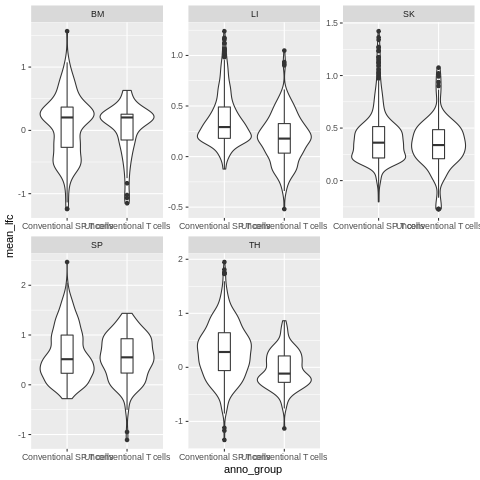

In [666]:
%%R -i tcells
tcells %>%
 group_by(Nhood, anno_group, organ) %>%
    summarise(mean_lfc=mean(logFC)) %>%
#     head() %>%
    ggplot(aes(anno_group, mean_lfc)) +
    geom_violin(scale='width') +
    geom_boxplot(width=0.2) +
    facet_wrap(organ~., scales='free')
#     pivot_wider(id_cols=c(Nhood, organ), names_from=anno_group, values_from=mean_lfc) %>%
#     head()
